In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.optimize import newton, root
from scipy.interpolate import interp1d
from scipy.integrate import solve_bvp, solve_ivp
from numpy.linalg import norm

from scipy import integrate
from scipy.stats import linregress
import pandas as pd

import time
plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['legend.fontsize'] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["figure.titlesize"] = 24
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Jamiton

In [2]:
# One dimensional Newton
def newton_1D(x_0, f, f_prime, tol=1e-8):
    x_k = x_0
    error = np.add.reduce(np.abs(f(x_k)))
    while error > tol:
        f_1 = -f(x_k)
        f_2 = f_prime(x_k)
        delta_x = f_1/f_2
        x_k_1 = x_k + delta_x
        error = norm([x_k - x_k_1], 2)
        x_k = x_k_1
    if error != error:
        return 0, 1

    return x_k


In [3]:
gamma = 1/2
beta = 8
u_max = 20
rho_max = 1/7.5

c = 0.078 * u_max * rho_max
b = 1/3
l = 1/10
tau = 10

def h(rho):
    output = beta * (rho /(rho_max - rho))**gamma
    return output

def h_prime(rho):
    output =  beta * gamma * (rho /(rho_max - rho))**(gamma-1) * rho_max / ((rho_max - rho)**2)
    return output

def g(y):
    output = np.sqrt(1 + ((y-b)/l)**2 )
    return output

def g_prime(y):
    output = (1/l**2) * ((y-b)/ np.sqrt(1 + ((y-b)/l)**2)) 
    return output

def Q_e(rho):
    output = c * (g(0) + (((g(1) - g(0)) * rho/rho_max)) - g(rho/rho_max))
    return output

def Q_prime(rho):
    output = c * ( ((g(1) - g(0))/rho_max) - (g_prime(rho/rho_max)/rho_max))
    return output

# Velocidad de equilibrio
def U(rho):
    output = Q_e(rho)/rho
    return output

# Derivada de la velocidad de equilibrio
def U_prime(rho):
    output = (Q_prime(rho) - U(rho))/np.sqrt((rho**2 + 1e-5**2))
    return output

# Funciones del modelo
def h_bar(v):
    return h(1/v)

def h_bar_prime(v):
    output = -h_prime(1/v)/v**2 
    return output

def U_bar(v):
    return U(1/v)

def U_bar_prime(v):
    return -U_prime(1/v)/v**2

def w_v(v, m, s):
    output = U_bar(v) - (m * v + s)
    return output

def w_v_prime(v, m, s):
    output = U_bar_prime(v) - m
    return output

def r(v, m):
    output = m * h_bar(v) + m**2 * v
    return output

def r_prime(v, m):
    output = m * h_bar_prime(v) + m**2
    return output

# Transforma rho a u
def rho_to_u(rho, m, s):
    u = (m/rho) + s
    return u

# Transforma v a rho
def v_to_rho(v):
    rho = 1/v
    return rho

def ode_jam_v(x, v, tau, m, s):
    output = w_v(v, m, s)/(r_prime(v, m) * v * tau)
    return output

def ode_jam_v_eta(eta, v, m, s):
    output = w_v(v, m, s)/(r_prime(v, m) * v)
    return output

In [4]:
# Elección valores sónicos
rho_min_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.1*rho_max, method="lm").x[0]
rho_max_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.7*rho_max, method="lm").x[0]

rho_s = 0.43334728629845265 * rho_max #0.43334728629845265 * rho_max #0.385 * rho_max # 0.64
v_s = 1/rho_s # Se necesita rho_s normalizado

m_bar = -h_bar_prime(v_s)
s_bar = U_bar(v_s) - m_bar * v_s

In [5]:
v_M  = newton_1D(50, lambda v: w_v(v, m_bar, s_bar), lambda v: w_v_prime(v, m_bar, s_bar))
r_min = r(v_s, m_bar)
r_max = r(v_M, m_bar)

v_R = root(lambda v: r(v, m_bar) - r_max, 10).x[0]

# Jamiton actual
v_minus = (v_M + v_s)/2
r_minus = r(v_minus, m_bar)
v_plus = newton_1D(8, lambda v: r(v, m_bar) - r_minus, lambda v: r_prime(v, m_bar))
r_plus = r(v_plus, m_bar)

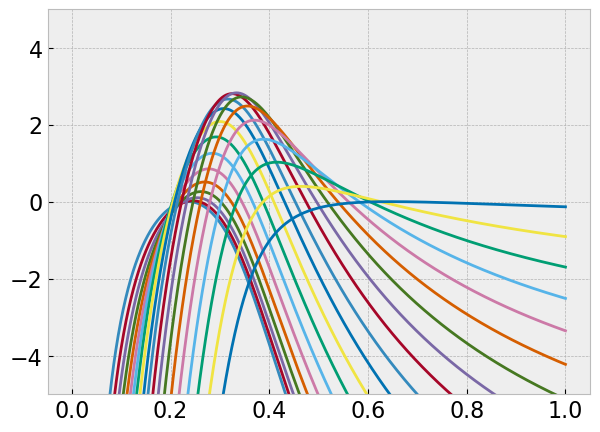

In [6]:
rhos_s = np.linspace(rho_min_scc, rho_max_scc, 20)
vs_s = 1/rhos_s

ms_bar = -h_bar_prime(vs_s)
ss_bar = U_bar(vs_s) - ms_bar * vs_s

v_to_plot = np.linspace(1, 55, 1000)
rho_to_plot = np.linspace(0, 1, 1000)[1:]*rho_max
v_to_plot = 1/rho_to_plot
for j in range(len(rhos_s)):
    
    plt.plot(rho_to_plot/rho_max, w_v(v_to_plot, ms_bar[j], ss_bar[j]), label=r"$\rho$={}".format(round(rhos_s[j]/rho_max, 3)))

#plt.legend(fontsize=10)
#plt.hlines(0, 8, 60, ls="--")
plt.ylim(-5, 5)
plt.show()

In [14]:
# Resuelve EDO
t_f = 150
N_ODE = int(1e7)
sol_v = solve_ivp(ode_jam_v, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, N_ODE), args=[tau, m_bar, s_bar], dense_output=True)
sol_v_eta = solve_ivp(ode_jam_v_eta, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, N_ODE), args=[m_bar, s_bar], dense_output=True)

sol_rho = lambda x: 1/sol_v.sol(x)[0]
sol_u = lambda x: rho_to_u(sol_rho(x), m_bar, s_bar)

sol_rho_eta = lambda x: 1/sol_v_eta.sol(x)[0]
sol_u_eta = lambda x: rho_to_u(sol_rho_eta(x), m_bar, s_bar)

# Encuentra xs
x_minus = newton(lambda v: sol_v.sol(v)[0] - v_minus, v_minus)
x_plus = newton(lambda v: sol_v.sol(v)[0] - v_plus, 0)

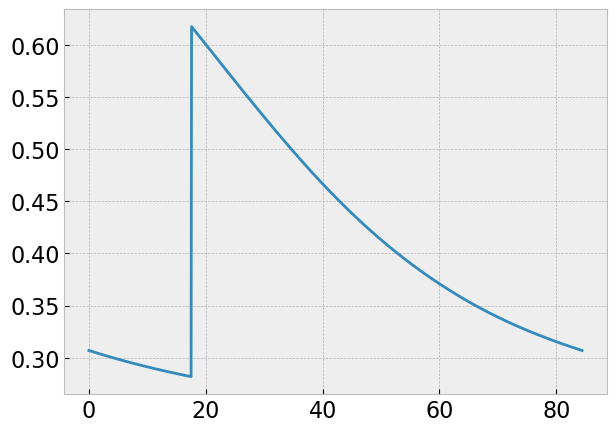

In [16]:
#x_s = newton(lambda v: sol_v.sol(v)[0] - v_s, 0)
#x_to_plot = sol_v.t

# Jamiton actual
#x_jam = np.linspace(x_plus, x_minus, 500)
#v_jam = sol_v.sol(x_jam)[0]

def rho_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_rho(x_per)

def u_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_u(x_per)

L = np.abs(x_minus-x_plus)
x_to_plot = np.linspace(0, L, 1000)#np.linspace(0, L, 1000)
des = 55

plt.plot(x_to_plot, rho_per(x_to_plot)/rho_max)
plt.show()

# Simulation

In [22]:
# Jamiton creation
tau = 10
rho_s = 0.433 * rho_max#0.6 * rho_max #0.43334728629845265 * rho_max #0.385 * rho_max # 0.3
v_s = 1/rho_s # Se necesita rho_s normalizado

m_bar = -h_bar_prime(v_s)
s_bar = U_bar(v_s) - m_bar * v_s

v_M  = newton_1D(50, lambda v: w_v(v, m_bar, s_bar), lambda v: w_v_prime(v, m_bar, s_bar))
r_min = r(v_s, m_bar)
r_max = r(v_M, m_bar)

v_R = root(lambda v: r(v, m_bar) - r_max, 10).x[0]

# Jamiton actual
v_minus = 26 #(v_M + v_s)/2
r_minus = r(v_minus, m_bar)
v_plus = newton_1D(8, lambda v: r(v, m_bar) - r_minus, lambda v: r_prime(v, m_bar))
r_plus = r(v_plus, m_bar)

# Resuelve EDO
t_f = 150
sol_v = solve_ivp(ode_jam_v, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, 1_000_000), args=[tau, m_bar, s_bar], dense_output=True)
sol_v_eta = solve_ivp(ode_jam_v_eta, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, N_ODE), args=[m_bar, s_bar], dense_output=True)

sol_rho = lambda x: 1/sol_v.sol(x)[0]
sol_u = lambda x: rho_to_u(sol_rho(x), m_bar, s_bar)
sol_rho_eta = lambda x: 1/sol_v_eta.sol(x)[0]
sol_u_eta = lambda x: rho_to_u(sol_rho_eta(x), m_bar, s_bar)

# Encuentra xs
x_minus = newton(lambda v: sol_v.sol(v)[0] - v_minus, v_s)
x_plus = newton(lambda v: sol_v.sol(v)[0] - v_plus, 0)

In [448]:
## get s_max
rho_s_zero = root(lambda rho: U_prime(rho) + h_prime(rho), 0.2*rho_max).x[0]
v_s_zero = 1/rho_s_zero
m_max = -h_bar_prime(v_s_zero)
s_max = U_bar(v_s_zero) - m_max * v_s_zero

In [449]:
def flux_rho(rho, y):
    return y-rho*h(rho)

def flux_y(rho, y):
    return (y**2)/rho - h(rho)*y


def F_LxF_rho(rho, y, l):
    rho_left = np.roll(rho, 1)
    y_left = np.roll(y, 1)

    rho_right = np.roll(rho, -1)
    y_right = np.roll(y, -1)

    flux = flux_rho(rho, y)
    flux_right = flux_rho(rho_right, y_right)
    flux_left = flux_rho(rho_left, y_left)

    flux_bar_right = (flux_right + flux)/2 - (rho_right - rho)/(2*l)
    flux_bar_left = (flux_left + flux)/2 - (rho - rho_left)/(2*l)

    return flux_bar_right - flux_bar_left


def F_LxF_y(rho, y, l):
    rho_left = np.roll(rho, 1)
    y_left = np.roll(y, 1)

    rho_right = np.roll(rho, -1)
    y_right = np.roll(y, -1)

    flux = flux_y(rho, y)
    flux_right = flux_y(rho_right, y_right)
    flux_left = flux_y(rho_left, y_left)

    flux_bar_right = (flux_right + flux)/2 - (y_right - y)/(2*l)
    flux_bar_left = (flux_left + flux)/2 - (y - y_left)/(2*l)

    return flux_bar_right - flux_bar_left

In [450]:
def ARZ_simulation(Q_0, x, tau, T, Nt, F_rho, F_y, as_array=True):

    t = np.linspace(0, T, Nt)
    dt = t[1] - t[0]

    # salto espacial
    dx = x[1] - x[0]
    N = len(x)

    CFL = 2 * s_max * dt/dx < 1

    if not CFL:
        print("CFL is not satisfied")
        pass

    # Guarda soluciones
    # Condición inicial

    if as_array:
        rho = np.zeros((Nt, N))
        y = np.zeros((Nt, N))

        rho[0] = Q_0[0]
        y[0] = Q_0[1]

    else:
        rho = Q_0[0]
        y = Q_0[1]

    for n in range(Nt-1):
        print("Step ", n, " of ", Nt)
        l = dt/dx

        if as_array:
            rho_n = rho[n]
            y_n = y[n]

        else:
            rho_n = rho
            y_n = y
        
        # Paso de Godunov
        rho_sig = rho_n - l * F_rho(rho_n, y_n, l)
        y_sig = y_n - l * F_y(rho_n, y_n, l)
        
        # Resuelve termino de relajación
        alpha = dt/tau

        # Implícito
        y_sig_ = (alpha/(1+alpha)) * rho_sig * (U(rho_sig) + h(rho_sig)) + (1/(1+alpha)) * y_sig
        y_sig = y_sig_

        # Guarda paso
        if as_array:
            rho[n+1] = rho_sig
            y[n+1] = y_sig

        else:
            rho = rho_sig
            y = y_sig

    return t, rho, y

In [451]:
def rho_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_rho(x_per)

def u_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_u(x_per)

def teo_rho_eta(x, t, s=s_bar):
    eta_minus = x_minus / tau
    eta_plus = x_plus / tau
    eta = (x - s*t)/tau
    interval = eta_minus - eta_plus
    eta_per = (eta - eta_plus) % interval + eta_plus

    return sol_rho_eta(eta_per)

def teo_u_eta(x, t, s=s_bar):
    eta_minus = x_minus / tau
    eta_plus = x_plus / tau
    eta = (x - s*t)/tau
    interval = eta_minus - eta_plus
    eta_per = (eta - eta_plus) % interval + eta_plus

    return sol_u_eta(eta_per)

In [452]:
T = 2
#Nt = 50_000
#N = 5_000 #500_000
L = np.abs(x_minus-x_plus)
dx = 2**(-5)/10 #L/(N-1)
N = int(L/dx) + 1
x = np.linspace(0, L, N)#np.linspace(0, L, 1000)

dt = dx/(2.1*s_max) # CFL
Nt = int(T/dt + 1)

rho_0 = rho_per(x) #rho_per(x)
u_0 = u_per(x) #u_per(x)
y_0 = rho_0 * (u_0 + h(rho_0))
Q_0 = [rho_0, y_0] #[np.zeros(N), np.zeros(N)]
t, rho, y = ARZ_simulation(Q_0, x, tau, T, Nt, F_LxF_rho, F_LxF_y, as_array=False)
u = y/rho - h(rho)

Step  0  of  21436
Step  1  of  21436
Step  2  of  21436
Step  3  of  21436
Step  4  of  21436
Step  5  of  21436
Step  6  of  21436
Step  7  of  21436
Step  8  of  21436
Step  9  of  21436
Step  10  of  21436
Step  11  of  21436
Step  12  of  21436
Step  13  of  21436
Step  14  of  21436
Step  15  of  21436
Step  16  of  21436
Step  17  of  21436
Step  18  of  21436
Step  19  of  21436
Step  20  of  21436
Step  21  of  21436
Step  22  of  21436
Step  23  of  21436
Step  24  of  21436
Step  25  of  21436
Step  26  of  21436
Step  27  of  21436
Step  28  of  21436
Step  29  of  21436
Step  30  of  21436
Step  31  of  21436
Step  32  of  21436
Step  33  of  21436
Step  34  of  21436
Step  35  of  21436
Step  36  of  21436
Step  37  of  21436
Step  38  of  21436
Step  39  of  21436
Step  40  of  21436
Step  41  of  21436
Step  42  of  21436
Step  43  of  21436
Step  44  of  21436
Step  45  of  21436
Step  46  of  21436
Step  47  of  21436
Step  48  of  21436
Step  49  of  21436
Step  50  


KeyboardInterrupt



In [138]:
# Notas
# Usar Nt = 10^6 para todos los errores
# Maximo N = 500_000
# El Nt cumple CFL para todo N menor a 500_000
# Esto aplica para un rho_s (0.433...). 
# Para otros jamitones, se pueden usar muchos mas puntos porque el largo del jamiton cambia
# Una ideales en vez de variar N, variar dx. Así me quito de encima la "dependencia" en L

In [432]:
j = 0
100 * norm(teo_rho_eta(x, T+j*dt) - rho, 1)/norm(teo_rho_eta(x, T+j*dt), 1)

0.051364419900508516

In [433]:
j = 0
100*norm(rho_per(x-s_bar*(T+j*dt)) - rho, 1)/norm(rho_per(x-s_bar*(T+j*dt)), 1)

0.06071150613877002

In [374]:
dxs = [(2)**(-j)/10 for j in range(3, 11)]
dxs[-1]

9.765625e-05

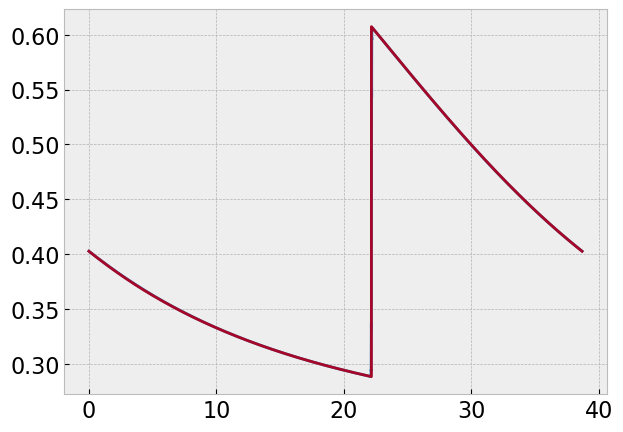

In [445]:
plt.plot(x, rho/rho_max)
plt.plot(x, teo_rho_eta(x, T)/rho_max)

In [ ]:
plt.plot(x, rho[10]/rho_max)
plt.plot(x, rho[1000]/rho_max)
plt.plot(x, rho[Nt//2]/rho_max)
plt.plot(x, rho[-1]/rho_max)

plt.plot(x, rho_per(x-s_bar*T)/rho_max)

In [ ]:
norm(rho_per(x-s_bar*T) - rho[-1], 1)/norm(rho_per(x-s_bar*T), 1)